# Encoder-Decoder vs nn.Transformer Testing

### Create Dataloaders

In [1]:
import sys
sys.path.append("..")

from basic_transformer import TransformerEncDec
from basic_tokenizers import ByteTextTokenizer
from helpers import total_params

from fastai.text.all import *
from fastai.basics import *

No module named 'axial_positional_embedding'


In [2]:
path = Path('..')
df = pd.read_csv(path/'en_ga_prep.csv', index_col=0)
df.head()

,clean,en,en_len,ga,ga_len
0,True,"Among the French PIM , in 2013, it is only 9 islands that have been chiroptérologiques inventories .",18,"I measc na PIM Fraince, i 2013, tá sé ach 9 oileáin a bhí chiroptérologiques fardail.",16
1,True,"Among the French PIM, in 2013, it is only 9 islands that have been chiroptérologiques inventories.",16,"I measc na PIM Fraince , i 2013, tá sé ach 9 oileáin a bhí chiroptérologiques fardail .",18
2,True,"Among the French PIM, in 2013, it is only 9 islands that have been chiroptérologiques inventories.",16,"I measc na PIM Fraince, i 2013, tá sé ach 9 oileáin a bhí chiroptérologiques fardail.",16
3,True,"As you can see, so get to show off the spacious shapes in 3D (red and blue).",17,"Mar is féidir leat a fheiceáil, a fháil mar sin a thaispeáint as na cruthanna mhór i 3D (dearg agus gorm).",21
4,True,"Equation Solving – Traditional, simple",5,"Ligningsløsning – Traidisiúnta, simplí",4


In [3]:
#df = df[:32]

def add_eos(text):
    return text + f' {EOS}'

dblock = DataBlock(blocks=(TextBlock.from_df('en', tok_text_col='en', rules=[add_eos]),
                           TextBlock.from_df('ga', tok_text_col='ga', rules=[add_eos])),
                   get_x=ColReader('en'),
                   get_y=ColReader('ga'), 
                   splitter=RandomSplitter())

dsets = dblock.datasets(df)

pad_seq2seq = partial(pad_input, pad_fields=[0,1])

dls = dsets.dataloaders(bs=16, dl_type=SortedDL, before_batch=pad_seq2seq)
dls.show_batch(max_n=4)

/home/morgan/anaconda3/envs/fastai_env/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


,text,text_
0,"( 6 ) In this section “ personal reliefs ” means any relief under section 32 of the Income Tax Act , 1918 , under sections 16 , 18 , 19 , 20 , 21 , 22 , and 23 of the Finance Act , 1920 , under section 4 of the Finance Act , 1951 ( No . 15 of 1951 ) , or under section 3 of the Finance Act , 1954 ( No . 22 of 1954 ) . xxeos","( 6 ) San alt seo , ciallaíonn “ faoisimh phearsanta ” aon fhaoiseamh faoi alt 32 den Income Tax Act , 1918 , faoi ailt 16 , 18 , 19 , 20 , 21 , 22 agus 23 den Finance Act , 1920 , faoi alt 4 den Acht Airgeadais , 1951 ( Uimh . 15 de 1951 ) , nó faoi alt 3 den Acht Airgeadais , 1954 ( Uimh . 22 de 1954 ) . xxeos"
1,13 . —Section 2 of the Superannuation Act of 1942 ( which section relates to payment of superannuation benefits to members of the Board ) is hereby amended by the insertion in subsection ( 1 ) before the words “ two or more periods ” of the words “ not less than ten years of continuous whole - time membership of the Board or after ” . xxeos xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad,13 . —Déantar leis seo alt 2 d'Acht Aoisliúntais 1942 ( alt a xxunk le sochair aoisliúntais d'íoc le comhaltaí den Bhord ) a leasú trí na focail “ tréimhse leanúnach nach 1ú ná deich mbliana de chomhaltas lán - aimsire sa Bhord nó tar éis ” a chur isteach i bhfo - alt ( 1 ) roimh na focail “ dhá thréimhse nó níos mó ” . xxeos xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad
2,"then , in determining for the purposes of the preceding provisions of this paragraph the amount of the fund 's income for that account period , there shall be allowed as a deduction any amount which , apart from this subparagraph , would form part of the income of the fund for that account period and which can not be distributed by virtue of the restriction . xxeos xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad","ansin , le linn méid ioncam an chiste don tréimhse chuntais sin a bheith á chinneadh chun críocha na bhforálacha sin roimhe seo den mhír seo , lamhálfar mar asbhaint aon mhéid a bheadh , ar leith ón bhfomhír seo , ina chuid d'ioncam an chiste don tréimhse chuntais sin agus nach féidir a dháileadh de bhua an tsriain . xxeos xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad"
3,"( b ) The provisions of this subsection shall , subject to any necessary modifications , apply to the rehearing of an appeal by a judge of the Circuit Court and , to the extent necessary , to the determination by the High Court of any question or questions of law arising on the statement of a case for the opinion of the High Court . xxeos xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad","( b ) Beidh feidhm , faoi réir aon mhodhnuithe is gá , ag forálacha an fho - ailt seo maidir le hathéisteacht achomhairc ag breitheamh den Chúirt Chuarda agus , a mhéid is gá sin , maidir leis an Ard - Chúirt do chinneadh aon cheist nó ceisteanna dlí a éireoidh de bharr cás a shonrú chun tuairim na hArd - Chúirte a fháil air . xxeos xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad"


In [4]:
class CombineInputOutputCallback(Callback):
    '''Callback to combine the input and target text into self.xb'''
    def __init__(self): pass
    def before_batch(self): 
        self.learn.xb = (self.xb[0], self.yb[0])

class RemoveEOSCallback(Callback):
    '''
        Shift the target presented to the model during training to remove the "eos" token as 
        we don't want the model to learn to translate EOS when it sees EOS.
        
        In practice we actually mask the EOS token as due to batching the last token will often be a <pad> token,
        not EOS
    '''
    def __init__(self, eos_idx): self.eos_idx=eos_idx
    def before_batch(self):        
        eos_mask=(self.learn.xb[1]!=self.eos_idx)
        sz=torch.tensor(self.learn.xb[1].size())
        sz[1]=sz[1]-1
        self.learn.xb = (self.learn.xb[0], self.learn.xb[1][eos_mask].view((sz[0],sz[1])))

class LossTargetShiftCallback(Callback):
    '''
        Shift the target shown to the loss to exclude the "bos" token as the first token we want predicted
        should be an actual word, not the "bos" token (as we have already given the model "bos" )
    '''
    def __init__(self): pass
    def after_pred(self): 
        self.learn.yb = (self.learn.yb[0][:,1:],)

In [5]:
en_vocab_sz = len(dls.vocab[0])
ga_vocab_sz = len(dls.vocab[1])
d_model = 768

xb, yb = dls.one_batch()
xb.shape, yb.shape

((16, 83), (16, 79))

# Start Testing
### Standard Attention Test

In [6]:
import wandb
from fastai.callback.wandb import *

WANDB_NAME = 'standard_attn'
GROUP = 'TEST'     # Group to add a run to, e.g. "LSH" for LSH experiments, "REVERSIBLE" for reversible layers
NOTES = 'Testing standard attention ("self" followed by "cross") in the decoder'
CONFIG = {}
TAGS =['std_attn','enc_dec','test']

wandb.init(reinit=True, project="reformer-fastai", entity="fastai_community", 
           name=WANDB_NAME, group=GROUP, notes=NOTES,  tags=TAGS) 

wandb: Currently logged in as: morgan (use `wandb login --relogin` to force relogin)


In [7]:
cbs = [CombineInputOutputCallback(), RemoveEOSCallback(dls.o2i[0][EOS]), LossTargetShiftCallback(), WandbCallback(log_model=False, log_preds=False)]

enc_dec_model = TransformerEncDec(en_vocab_sz, ga_vocab_sz, dim=d_model, depth=6, heads=8, 
                 max_seq_len=256, pad_idx=dls.o2i[0][PAD], tie_weights=True, 
                 attn_dropout=0.1, ff_dropout=0.1, emb_dropout=0.1,
                 pos_enc='absolute', d_ff=None, comb_attn=False)

arto_encdec_learn = Learner(dls, enc_dec_model,
                loss_func=CrossEntropyLossFlat(ignore_index=1), cbs=cbs,
                metrics=[accuracy, CorpusBLEUMetric()]).to_native_fp16()

In [8]:
total_params(arto_encdec_learn.model)[0]

157406200

SuggestedLRs(lr_min=0.00831763744354248, lr_steep=0.0691830962896347)

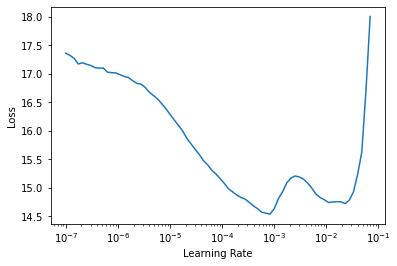

In [9]:
arto_encdec_learn.lr_find()

In [ ]:
arto_encdec_learn.fit_one_cycle(3, 1e-4, div=5)  

epoch     train_loss  valid_loss  accuracy  corpus_bleu  time    
0         2.931959    2.805808    0.417621  0.218139     32:36     
1         2.187685    2.053260    0.508922  0.323319     33:07     


In [ ]:
arto_encdec_learn.recorder.final_record

In [ ]:
arto_encdec_learn.recorder.plot_loss()

### Combined Attention Test

In [6]:
import wandb
from fastai.callback.wandb import *

WANDB_NAME = 'comb_attn'
GROUP = 'TEST'     # Group to add a run to, e.g. "LSH" for LSH experiments, "REVERSIBLE" for reversible layers
NOTES = 'Testing combined attention performance'
CONFIG = {}
TAGS =['comb_attn','test']

wandb.init(reinit=True, project="reformer-fastai", entity="fastai_community", 
           name=WANDB_NAME, group=GROUP, notes=NOTES,  tags=TAGS) 

wandb: Currently logged in as: morgan (use `wandb login --relogin` to force relogin)


In [7]:
cbs = [CombineInputOutputCallback(), RemoveEOSCallback(dls.o2i[0][EOS]), LossTargetShiftCallback(), WandbCallback(log_model=False, log_preds=False)]

enc_dec_model_v2 = TransformerEncDec(en_vocab_sz, ga_vocab_sz, dim=d_model, depth=6, heads=8, 
                 max_seq_len=256, pad_idx=dls.o2i[0][PAD], tie_weights=True, 
                 attn_dropout=0.1, ff_dropout=0.1, emb_dropout=0.1,
                 pos_enc='absolute', d_ff=None, comb_attn=True)

arto_encdec_learn_v2 = Learner(dls, enc_dec_model_v2,
                loss_func=CrossEntropyLossFlat(ignore_index=1), cbs=cbs,
                metrics=[accuracy, CorpusBLEUMetric()]).to_native_fp16()

In [8]:
total_params(arto_encdec_learn_v2.model)[0]

143236600

SuggestedLRs(lr_min=0.0033113110810518267, lr_steep=0.02754228748381138)

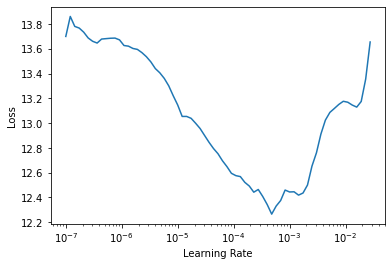

In [9]:
arto_encdec_learn_v2.lr_find()

In [10]:
arto_encdec_learn_v2.fit_one_cycle(3, 1e-4, div=5)  

epoch     train_loss  valid_loss  accuracy  corpus_bleu  time    
0         2.885687    2.746036    0.418986  0.216402     28:35     
1         2.192592    2.023778    0.506025  0.319416     28:53     
2         1.927862    1.847105    0.528554  0.348970     29:07     


In [11]:
arto_encdec_learn_v2.recorder.final_record

(#4) [1.9278624057769775,1.8471053838729858,0.5285536646842957,0.3489696940400926]

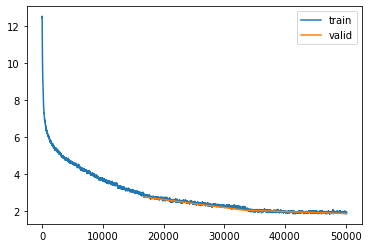

In [12]:
arto_encdec_learn_v2.recorder.plot_loss()

### Combined Attention Test 2

In [6]:
import wandb
from fastai.callback.wandb import *

WANDB_NAME = 'comb_attn_2'
GROUP = 'TEST'     # Group to add a run to, e.g. "LSH" for LSH experiments, "REVERSIBLE" for reversible layers
NOTES = 'Testing combined attention performance'
CONFIG = {}
TAGS =['comb_attn','test']

wandb.init(reinit=True, project="reformer-fastai", entity="fastai_community", 
           name=WANDB_NAME, group=GROUP, notes=NOTES,  tags=TAGS) 

wandb: Currently logged in as: morgan (use `wandb login --relogin` to force relogin)


In [7]:
cbs = [CombineInputOutputCallback(), RemoveEOSCallback(dls.o2i[0][EOS]), LossTargetShiftCallback(), WandbCallback(log_model=False, log_preds=False)]

enc_dec_model_v2 = TransformerEncDec(en_vocab_sz, ga_vocab_sz, dim=d_model, depth=6, heads=8, 
                 max_seq_len=256, pad_idx=dls.o2i[0][PAD], tie_weights=True, 
                 attn_dropout=0.1, ff_dropout=0.1, emb_dropout=0.1,
                 pos_enc='absolute', d_ff=None, comb_attn=True)

arto_encdec_learn_v2 = Learner(dls, enc_dec_model_v2,
                loss_func=CrossEntropyLossFlat(ignore_index=1), cbs=cbs,
                metrics=[accuracy, CorpusBLEUMetric()]).to_native_fp16()

In [8]:
total_params(arto_encdec_learn_v2.model)[0]

143236600

SuggestedLRs(lr_min=0.0019054606556892395, lr_steep=0.015848932787775993)

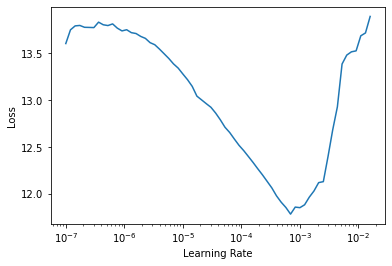

In [9]:
arto_encdec_learn_v2.lr_find()

In [10]:
arto_encdec_learn_v2.fit_one_cycle(3, 4e-5, div=5)  

epoch     train_loss  valid_loss  accuracy  corpus_bleu  time    
0         3.495989    3.370661    0.349298  0.148550     28:48     
1         2.665388    2.538576    0.439969  0.236671     28:58     
2         2.528175    2.367687    0.459777  0.259018     28:59     


In [11]:
arto_encdec_learn_v2.recorder.final_record

(#4) [2.528174877166748,2.3676867485046387,0.45977702736854553,0.25901763062238564]

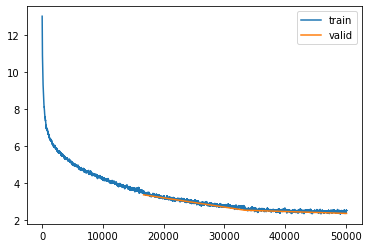

In [12]:
arto_encdec_learn_v2.recorder.plot_loss()

In [13]:
1e-4

0.0001

### Combined Attention Test - With Bias

In [6]:
import wandb
from fastai.callback.wandb import *

WANDB_NAME = 'comb_attn_bias'
GROUP = 'TEST'     # Group to add a run to, e.g. "LSH" for LSH experiments, "REVERSIBLE" for reversible layers
NOTES = 'Testing combined attention performance, now with attn bias'
CONFIG = {}
TAGS =['comb_attn','test']

wandb.init(reinit=True, project="reformer-fastai", entity="fastai_community", 
           name=WANDB_NAME, group=GROUP, notes=NOTES,  tags=TAGS) 

wandb: Currently logged in as: morgan (use `wandb login --relogin` to force relogin)


In [7]:
cbs = [CombineInputOutputCallback(), RemoveEOSCallback(dls.o2i[0][EOS]), LossTargetShiftCallback(), WandbCallback(log_model=False, log_preds=False)]

enc_dec_model = TransformerEncDec(en_vocab_sz, ga_vocab_sz, dim=d_model, depth=6, heads=8, 
                 max_seq_len=256, pad_idx=dls.o2i[0][PAD], tie_weights=True, 
                 attn_dropout=0.1, ff_dropout=0.1, emb_dropout=0.1,
                 pos_enc='absolute', d_ff=None, comb_attn=True)

arto_encdec_learn = Learner(dls, enc_dec_model,
                loss_func=CrossEntropyLossFlat(ignore_index=1), cbs=cbs,
                metrics=[accuracy, CorpusBLEUMetric()]).to_native_fp16()

In [8]:
total_params(arto_encdec_learn.model)[0]

143264248

SuggestedLRs(lr_min=0.002754228748381138, lr_steep=0.02290867641568184)

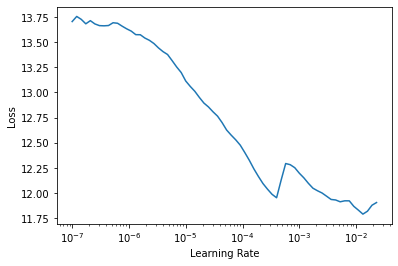

In [9]:
arto_encdec_learn.lr_find()

In [10]:
arto_encdec_learn.fit_one_cycle(3, 1e-4, div=5)  

epoch     train_loss  valid_loss  accuracy  corpus_bleu  time    
0         2.866454    2.790044    0.414243  0.213483     29:35     
1         2.108724    2.036595    0.504405  0.316999     29:50     
2         1.849122    1.866746    0.526252  0.345954     29:58     


In [11]:
arto_encdec_learn.recorder.final_record

(#4) [1.8491219282150269,1.8667458295822144,0.5262517929077148,0.3459543054032846]

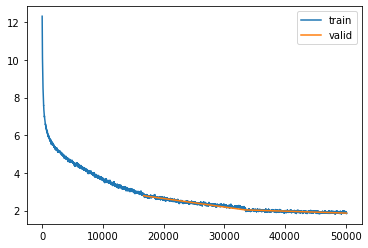

In [12]:
arto_encdec_learn.recorder.plot_loss()

# TODO TRY

MAKE SIMILAR:
- DEC D/O == 0.1
- NO EMBEDDING INIT

TEST STD ATTENTION AGAIN

XAVIER

Fastai Embedding

### Combined Attention Test - With Bias, with Fixed Pos Enc

In [6]:
import wandb
from fastai.callback.wandb import *

WANDB_NAME = 'comb_attn_w_bias_fixed_pos_enc'
GROUP = 'TEST'     # Group to add a run to, e.g. "LSH" for LSH experiments, "REVERSIBLE" for reversible layers
NOTES = 'Comb atten, with attn bias and fixed positional encodings'
CONFIG = {}
TAGS =['comb_attn','test']

wandb.init(reinit=True, project="reformer-fastai", entity="fastai_community", 
           name=WANDB_NAME, group=GROUP, notes=NOTES,  tags=TAGS) 

wandb: Currently logged in as: morgan (use `wandb login --relogin` to force relogin)


In [7]:
cbs = [CombineInputOutputCallback(), RemoveEOSCallback(dls.o2i[0][EOS]), LossTargetShiftCallback(), WandbCallback(log_model=False, log_preds=False)]

enc_dec_model = TransformerEncDec(en_vocab_sz, ga_vocab_sz, dim=d_model, depth=6, heads=8, 
                 max_seq_len=256, pad_idx=dls.o2i[0][PAD], tie_weights=True, 
                 attn_dropout=0.1, ff_dropout=0.1, emb_dropout=0.1,
                 pos_enc='fixed', d_ff=None, comb_attn=True)

arto_encdec_learn = Learner(dls, enc_dec_model,
                loss_func=CrossEntropyLossFlat(ignore_index=1), cbs=cbs,
                metrics=[accuracy, CorpusBLEUMetric()]).to_native_fp16()

In [8]:
total_params(arto_encdec_learn.model)[0]

142871032

SuggestedLRs(lr_min=0.0019054606556892395, lr_steep=0.015848932787775993)

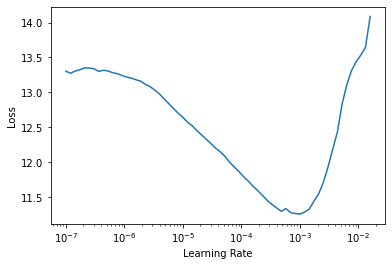

In [9]:
arto_encdec_learn.lr_find()

In [10]:
arto_encdec_learn.fit_one_cycle(3, 1e-4, div=5)  

epoch     train_loss  valid_loss  accuracy  corpus_bleu  time    
0         2.916460    2.739479    0.417634  0.215381     29:36     
1         2.059356    1.937698    0.515333  0.328397     29:51     
2         1.760409    1.752193    0.539392  0.361405     29:56     


In [11]:
arto_encdec_learn.recorder.final_record

(#4) [1.7604093551635742,1.7521926164627075,0.5393921732902527,0.3614046930420372]

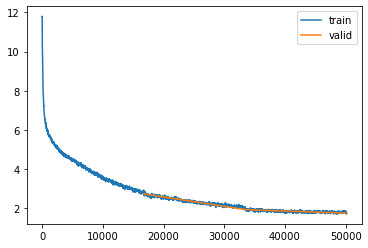

In [12]:
arto_encdec_learn.recorder.plot_loss()

### Combined Attention Test - 0. DecEmb Dropout, With Bias, with Fixed Pos Enc

(Later lets try no init for Emb)

In [6]:
import wandb
from fastai.callback.wandb import *

WANDB_NAME = 'comb_attn_decemb_dropout_bias_fixed_pos_enc'
GROUP = 'TEST'     # Group to add a run to, e.g. "LSH" for LSH experiments, "REVERSIBLE" for reversible layers
NOTES = 'Comb atten, with 0. dropout on Dec Embedding, no init on both embeddings, attn bias and fixed positional encodings'
CONFIG = {}
TAGS =['comb_attn','test']

wandb.init(reinit=True, project="reformer-fastai", entity="fastai_community", 
           name=WANDB_NAME, group=GROUP, notes=NOTES,  tags=TAGS) 

wandb: Currently logged in as: morgan (use `wandb login --relogin` to force relogin)


In [7]:
cbs = [CombineInputOutputCallback(), RemoveEOSCallback(dls.o2i[0][EOS]), LossTargetShiftCallback(), WandbCallback(log_model=False, log_preds=False)]

enc_dec_model = TransformerEncDec(en_vocab_sz, ga_vocab_sz, dim=d_model, depth=6, heads=8, 
                 max_seq_len=256, pad_idx=dls.o2i[0][PAD], tie_weights=True, 
                 attn_dropout=0.1, ff_dropout=0.1, emb_dropout=0.1,
                 pos_enc='fixed', d_ff=None, comb_attn=True)

arto_encdec_learn = Learner(dls, enc_dec_model,
                loss_func=CrossEntropyLossFlat(ignore_index=1), cbs=cbs,
                metrics=[accuracy, CorpusBLEUMetric()]).to_native_fp16()

In [8]:
total_params(arto_encdec_learn.model)[0]

142871032

SuggestedLRs(lr_min=0.0013182567432522773, lr_steep=0.010964781977236271)

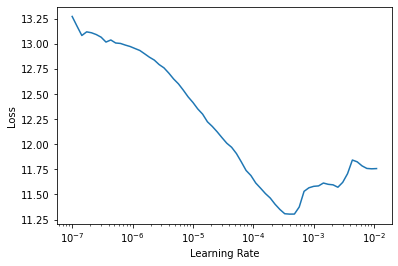

In [9]:
arto_encdec_learn.lr_find()

In [10]:
arto_encdec_learn.fit_one_cycle(3, 1e-4, div=5)  

epoch     train_loss  valid_loss  accuracy  corpus_bleu  time    
0         2.748984    2.746274    0.416022  0.210367     29:47     
1         2.064927    1.927488    0.517458  0.329349     30:15     
2         1.767836    1.748956    0.540681  0.361735     30:10     


In [11]:
arto_encdec_learn.recorder.final_record

(#4) [1.7678362131118774,1.7489556074142456,0.5406811833381653,0.361735374597604]

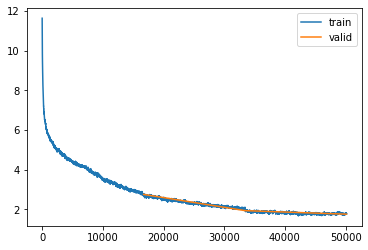

In [12]:
arto_encdec_learn.recorder.plot_loss()

### Combined Attention Test - with Xavier init, 0. DecEmb Dropout, with Bias, with Fixed Pos Enc

In [6]:
import wandb
from fastai.callback.wandb import *

WANDB_NAME = 'comb_attn_xavier_emb_drop_bias_fixed_pos_enc'
GROUP = 'TEST'     # Group to add a run to, e.g. "LSH" for LSH experiments, "REVERSIBLE" for reversible layers
NOTES = 'Comb atten, with Xavier attn init, with 0. dropout on Dec Embedding, attn bias and fixed positional encodings'
CONFIG = {}
TAGS =['comb_attn','test']

wandb.init(reinit=True, project="reformer-fastai", entity="fastai_community", 
           name=WANDB_NAME, group=GROUP, notes=NOTES,  tags=TAGS) 

wandb: Currently logged in as: morgan (use `wandb login --relogin` to force relogin)


In [7]:
cbs = [CombineInputOutputCallback(), RemoveEOSCallback(dls.o2i[0][EOS]), LossTargetShiftCallback(), WandbCallback(log_model=False, log_preds=False)]

enc_dec_model = TransformerEncDec(en_vocab_sz, ga_vocab_sz, dim=d_model, depth=6, heads=8, 
                 max_seq_len=256, pad_idx=dls.o2i[0][PAD], tie_weights=True, 
                 attn_dropout=0.1, ff_dropout=0.1, emb_dropout=0.1,
                 pos_enc='fixed', d_ff=None, comb_attn=True)

arto_encdec_learn = Learner(dls, enc_dec_model,
                loss_func=CrossEntropyLossFlat(ignore_index=1), cbs=cbs,
                metrics=[accuracy, CorpusBLEUMetric()]).to_native_fp16()

In [8]:
total_params(arto_encdec_learn.model)[0]

142871032

SuggestedLRs(lr_min=0.002290867641568184, lr_steep=0.019054606556892395)

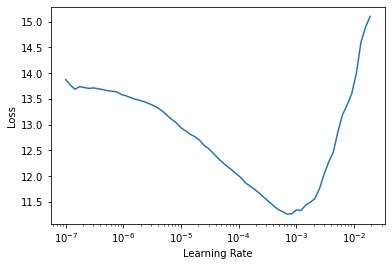

In [9]:
arto_encdec_learn.lr_find()

In [10]:
arto_encdec_learn.fit_one_cycle(3, 1e-4, div=5)  

epoch     train_loss  valid_loss  accuracy  corpus_bleu  time    
0         2.800165    2.695280    0.421994  0.217544     29:47     
1         2.090021    1.943626    0.515208  0.327859     30:07     
2         1.761525    1.764016    0.538204  0.359317     30:17     


In [11]:
arto_encdec_learn.recorder.final_record

(#4) [1.7615246772766113,1.7640161514282227,0.5382041931152344,0.35931738590597934]

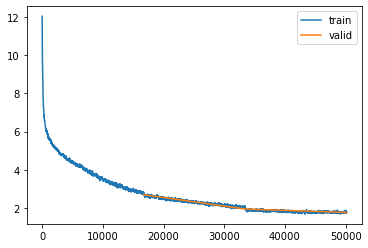

In [12]:
arto_encdec_learn.recorder.plot_loss()

### Combined Attention Test - with extra LayerNorms, Xavier init (Enc only), 0. DecEmb Dropout, with Bias, with Fixed Pos Enc

In [6]:
import wandb
from fastai.callback.wandb import *

WANDB_NAME = 'comb_attn_extra_LNs_xavier_emb_drop_bias_fixed_pos_enc'
GROUP = 'TEST'     # Group to add a run to, e.g. "LSH" for LSH experiments, "REVERSIBLE" for reversible layers
NOTES = 'Comb atten, with LNs at top of Encoder and Decoder, with Xavier attn init, with 0. dropout on Dec Embedding, attn bias and fixed positional encodings'
CONFIG = {}
TAGS =['comb_attn','test']

wandb.init(reinit=True, project="reformer-fastai", entity="fastai_community", 
           name=WANDB_NAME, group=GROUP, notes=NOTES,  tags=TAGS) 

wandb: Currently logged in as: morgan (use `wandb login --relogin` to force relogin)


In [7]:
cbs = [CombineInputOutputCallback(), RemoveEOSCallback(dls.o2i[0][EOS]), LossTargetShiftCallback(), WandbCallback(log_model=False, log_preds=False)]

enc_dec_model = TransformerEncDec(en_vocab_sz, ga_vocab_sz, dim=d_model, depth=6, heads=8, 
                 max_seq_len=256, pad_idx=dls.o2i[0][PAD], tie_weights=True, 
                 attn_dropout=0.1, ff_dropout=0.1, emb_dropout=0.1,
                 pos_enc='fixed', d_ff=None, comb_attn=True)

arto_encdec_learn = Learner(dls, enc_dec_model,
                loss_func=CrossEntropyLossFlat(ignore_index=1), cbs=cbs,
                metrics=[accuracy, CorpusBLEUMetric()]).to_native_fp16()

In [8]:
total_params(arto_encdec_learn.model)[0]

142874104

SuggestedLRs(lr_min=0.002290867641568184, lr_steep=0.019054606556892395)

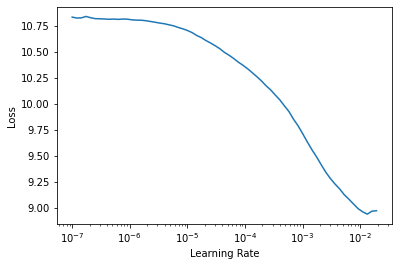

In [9]:
arto_encdec_learn.lr_find()

In [10]:
arto_encdec_learn.fit_one_cycle(3, 1e-4, div=5)  

epoch     train_loss  valid_loss  accuracy  corpus_bleu  time    
0         2.992909    2.901220    0.409828  0.203539     29:34     
1         2.109514    1.995960    0.514818  0.328608     29:45     
2         1.865992    1.814947    0.536726  0.356977     29:55     


In [11]:
arto_encdec_learn.recorder.final_record

(#4) [1.8659921884536743,1.8149467706680298,0.5367257595062256,0.35697714104711514]

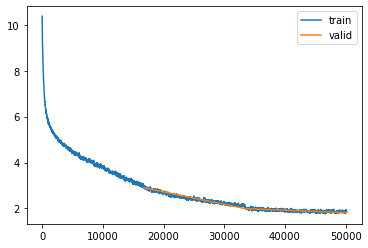

In [12]:
arto_encdec_learn.recorder.plot_loss()

### Combined Attention Test - FF set to 2048, with extra LayerNorms, Xavier init (Enc only), 0. DecEmb Dropout, with Bias, with Fixed Pos Enc

In [13]:
import wandb
from fastai.callback.wandb import *

WANDB_NAME = 'comb_attn_ff_2048_extra_LNs_xavier_bias_fixed_pos_enc'
GROUP = 'TEST'     # Group to add a run to, e.g. "LSH" for LSH experiments, "REVERSIBLE" for reversible layers
NOTES = 'Comb atten, FF layer size 2048, with LNs at top of Encoder and Decoder, with Xavier attn init, with 0. dropout on Dec Embedding, attn bias and fixed positional encodings'
CONFIG = {}
TAGS =['comb_attn','test','enc_dec']

wandb.init(reinit=True, project="reformer-fastai", entity="fastai_community", 
           name=WANDB_NAME, group=GROUP, notes=NOTES,  tags=TAGS) 

epoch,3
train_loss,1.86599
raw_loss,1.87801
wd_0,0.01
sqr_mom_0,0.99
lr_0,0.0
mom_0,0.95
eps_0,1e-05
_step,50135
_runtime,5369
_timestamp,1606609588


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train_loss,█▆▆▅▅▅▄▄▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
raw_loss,█▆▆▄▅▅▄▄▄▄▃▄▃▃▄▃▃▃▃▂▂▃▂▂▂▂▄▂▂▂▂▁▁▂▂▂▂▂▁▂
wd_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
sqr_mom_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr_0,▂▃▃▄▄▅▆▇████████▇▇▇▆▆▆▅▅▅▄▄▄▃▃▃▂▂▂▂▁▁▁▁▁
mom_0,██▇▆▅▄▃▂▂▁▁▁▁▁▁▁▂▂▂▃▃▃▄▄▄▅▅▅▆▆▆▇▇▇▇█████
eps_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


In [14]:
cbs = [CombineInputOutputCallback(), RemoveEOSCallback(dls.o2i[0][EOS]), LossTargetShiftCallback(), WandbCallback(log_model=False, log_preds=False)]

enc_dec_model = TransformerEncDec(en_vocab_sz, ga_vocab_sz, dim=d_model, depth=6, heads=8, 
                 max_seq_len=256, pad_idx=dls.o2i[0][PAD], tie_weights=True, 
                 attn_dropout=0.1, ff_dropout=0.1, emb_dropout=0.1,
                 pos_enc='fixed', d_ff=2048, comb_attn=True)

arto_encdec_learn = Learner(dls, enc_dec_model,
                loss_func=CrossEntropyLossFlat(ignore_index=1), cbs=cbs,
                metrics=[accuracy, CorpusBLEUMetric()]).to_native_fp16()

In [15]:
total_params(arto_encdec_learn.model)[0]

123987448

SuggestedLRs(lr_min=0.004786301031708717, lr_steep=0.03981071710586548)

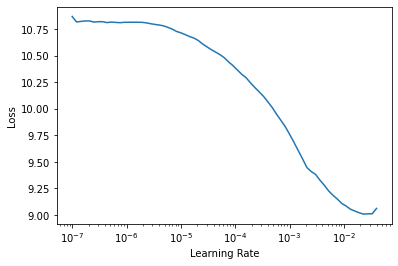

In [16]:
arto_encdec_learn.lr_find()

In [17]:
arto_encdec_learn.fit_one_cycle(3, 1e-4, div=5)  

epoch     train_loss  valid_loss  accuracy  corpus_bleu  time    
0         2.988914    2.928025    0.407688  0.200775     28:22     
1         2.156816    2.048322    0.509484  0.320258     28:26     
2         1.894120    1.868695    0.530897  0.349203     28:29     


In [18]:
arto_encdec_learn.recorder.final_record

(#4) [1.8941197395324707,1.8686953783035278,0.5308969616889954,0.34920346783875106]

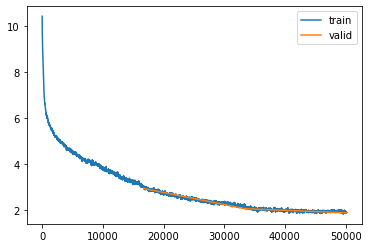

In [19]:
arto_encdec_learn.recorder.plot_loss()

### Standard Attention, FF set to 2048, with extra LayerNorms, Xavier init (Enc only), 0. DecEmb Dropout, with Bias, with Fixed Pos Enc

In [30]:
import wandb
from fastai.callback.wandb import *

WANDB_NAME = 'std_attn_ff_2048_extra_LNs_xavier_bias_fixed_pos_enc'
GROUP = 'TEST'     # Group to add a run to, e.g. "LSH" for LSH experiments, "REVERSIBLE" for reversible layers
NOTES = 'Standard atten, FF layer size 2048, with LNs at top of Encoder and Decoder, with Xavier attn init, attn bias and fixed positional encodings'
CONFIG = {}
TAGS =['std_attn','test','enc_dec']

wandb.init(reinit=True, project="reformer-fastai", entity="fastai_community", 
           name=WANDB_NAME, group=GROUP, notes=NOTES,  tags=TAGS) 

wandb: Currently logged in as: morgan (use `wandb login --relogin` to force relogin)


In [34]:
cbs = [CombineInputOutputCallback(), RemoveEOSCallback(dls.o2i[0][EOS]), LossTargetShiftCallback(), WandbCallback(log_model=False, log_preds=False)]

enc_dec_model = TransformerEncDec(en_vocab_sz, ga_vocab_sz, dim=d_model, depth=6, heads=8, 
                 max_seq_len=256, pad_idx=dls.o2i[0][PAD], tie_weights=True, 
                 attn_dropout=0.1, ff_dropout=0.1, emb_dropout=0.1,
                 pos_enc='fixed', d_ff=2048, comb_attn=False)

arto_encdec_learn = Learner(dls, enc_dec_model,
                loss_func=CrossEntropyLossFlat(ignore_index=1), cbs=cbs,
                metrics=[accuracy, CorpusBLEUMetric()]).to_native_fp16()

In [35]:
total_params(arto_encdec_learn.model)[0]

138170872

SuggestedLRs(lr_min=0.004786301031708717, lr_steep=0.03981071710586548)

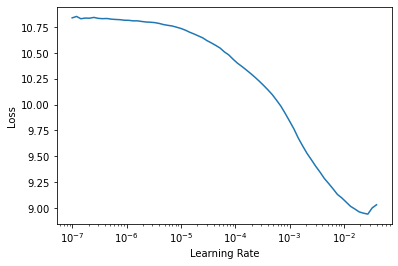

In [36]:
arto_encdec_learn.lr_find()

In [37]:
arto_encdec_learn.fit_one_cycle(3, 1e-4, div=5)  

epoch     train_loss  valid_loss  accuracy  corpus_bleu  time    
0         2.894949    2.764989    0.432499  0.230939     33:56     
1         2.130160    1.986251    0.519513  0.334184     34:24     
2         1.899886    1.829538    0.537887  0.359512     34:23     


In [38]:
arto_encdec_learn.recorder.final_record

(#4) [1.8998862504959106,1.8295384645462036,0.537887454032898,0.35951196298121657]

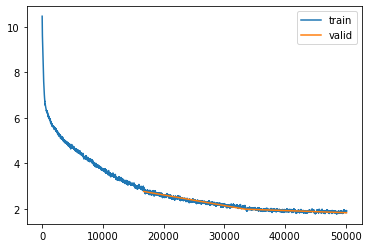

In [39]:
arto_encdec_learn.recorder.plot_loss()

### Standard Attention with all casual masking

Use causal masking in Encoder and Decoder Cross Attention, FF set to 2048, with extra LayerNorms, Xavier init (Enc only), 0. DecEmb Dropout, with Bias, with Fixed Pos Enc

In [15]:
import wandb
from fastai.callback.wandb import *

WANDB_NAME = 'std_attn_all_causal_INF_ff_2048_extra_LNs_xavier_bias_fixed_pos_enc'
GROUP = 'TEST'     # Group to add a run to, e.g. "LSH" for LSH experiments, "REVERSIBLE" for reversible layers
NOTES = 'Standard attention, causal masking in encoder, decoder attn and decoder cross attn, with negative INF masking, FF layer size 2048, with LNs at top of Encoder and Decoder, with Xavier attn init, attn bias and fixed positional encodings'
CONFIG = {}
TAGS =['std_attn','test','enc_dec']

wandb.init(reinit=True, project="reformer-fastai", entity="fastai_community", 
           name=WANDB_NAME, group=GROUP, notes=NOTES,  tags=TAGS) 

In [7]:
cbs = [CombineInputOutputCallback(), RemoveEOSCallback(dls.o2i[0][EOS]), LossTargetShiftCallback(), WandbCallback(log_model=False, log_preds=False)]

enc_dec_model = TransformerEncDec(en_vocab_sz, ga_vocab_sz, dim=d_model, depth=6, heads=8, 
                 max_seq_len=256, pad_idx=dls.o2i[0][PAD], tie_weights=True, 
                 attn_dropout=0.1, ff_dropout=0.1, emb_dropout=0.1,
                 pos_enc='fixed', d_ff=2048, comb_attn=False)

arto_encdec_learn = Learner(dls, enc_dec_model,
                loss_func=CrossEntropyLossFlat(ignore_index=1), cbs=cbs,
                metrics=[accuracy, CorpusBLEUMetric()]).to_native_fp16()

In [8]:
total_params(arto_encdec_learn.model)[0]

138170872

SuggestedLRs(lr_min=0.002754228748381138, lr_steep=0.02290867641568184)

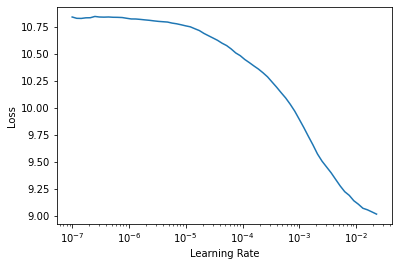

In [9]:
arto_encdec_learn.lr_find()

In [10]:
arto_encdec_learn.fit_one_cycle(3, 1e-4, div=5)  

epoch     train_loss  valid_loss  accuracy  corpus_bleu  time    
0         3.748788    3.626964    0.324704  0.125057     34:40     
1         3.096581    3.052617    0.380804  0.171553     34:58     
2         2.973355    2.907277    0.397357  0.186554     35:20     


In [11]:
arto_encdec_learn.recorder.final_record

(#4) [2.9733545780181885,2.9072773456573486,0.39735737442970276,0.1865541529073166]

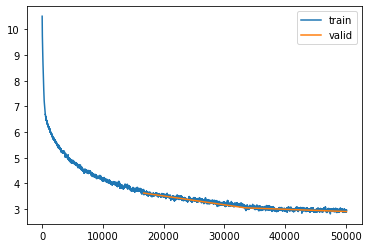

In [12]:
arto_encdec_learn.recorder.plot_loss()

### Standard Attention w/encoder casual masking

Use causal masking in Encoder and Decoder Cross Attention, FF set to 2048, with extra LayerNorms, Xavier init (Enc only), 0. DecEmb Dropout, with Bias, with Fixed Pos Enc

In [6]:
import wandb
from fastai.callback.wandb import *

WANDB_NAME = 'std_attn_encoder_causal_INF_ff_2048_extra_LNs_xavier_bias_fixed_pos_enc'
GROUP = 'TEST'     # Group to add a run to, e.g. "LSH" for LSH experiments, "REVERSIBLE" for reversible layers
NOTES = 'Standard attention, causal masking in encoder, decoder attn and decoder cross attn, with negative INF masking, FF layer size 2048, with LNs at top of Encoder and Decoder, with Xavier attn init, attn bias and fixed positional encodings'
CONFIG = {}
TAGS =['std_attn','test','enc_dec']

wandb.init(reinit=True, project="reformer-fastai", entity="fastai_community", 
           name=WANDB_NAME, group=GROUP, notes=NOTES,  tags=TAGS) 

wandb: Currently logged in as: morgan (use `wandb login --relogin` to force relogin)


In [7]:
cbs = [CombineInputOutputCallback(), RemoveEOSCallback(dls.o2i[0][EOS]), LossTargetShiftCallback(), WandbCallback(log_model=False, log_preds=False)]

enc_dec_model = TransformerEncDec(en_vocab_sz, ga_vocab_sz, dim=d_model, depth=6, heads=8, 
                 max_seq_len=256, pad_idx=dls.o2i[0][PAD], tie_weights=True, 
                 attn_dropout=0.1, ff_dropout=0.1, emb_dropout=0.1,
                 pos_enc='fixed', d_ff=2048, comb_attn=False)

arto_encdec_learn = Learner(dls, enc_dec_model,
                loss_func=CrossEntropyLossFlat(ignore_index=1), cbs=cbs,
                metrics=[accuracy, CorpusBLEUMetric()]).to_native_fp16()

In [8]:
total_params(arto_encdec_learn.model)[0]

138170872

SuggestedLRs(lr_min=0.0033113110810518267, lr_steep=0.02754228748381138)

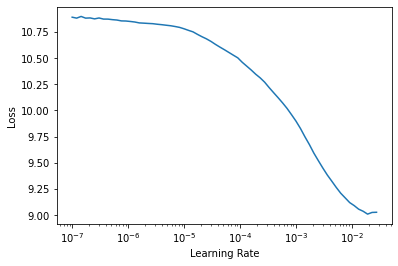

In [9]:
arto_encdec_learn.lr_find()

In [10]:
arto_encdec_learn.fit_one_cycle(3, 1e-4, div=5)  

epoch     train_loss  valid_loss  accuracy  corpus_bleu  time    
0         2.742191    2.685625    0.449648  0.252445     34:32     
1         2.120132    2.002269    0.519639  0.335916     34:50     
2         1.871145    1.850856    0.537130  0.359093     35:01     


In [11]:
arto_encdec_learn.recorder.final_record

(#4) [1.8711447715759277,1.8508561849594116,0.5371304154396057,0.35909258670260663]

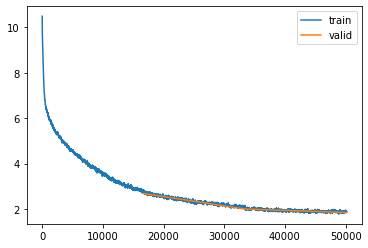

In [12]:
arto_encdec_learn.recorder.plot_loss()

### Standard Attention - w/fastai Embedding and encoder casual masking

Use causal masking in Encoder and Decoder Cross Attention, FF set to 2048, with extra LayerNorms, Xavier init (Enc only), 0. DecEmb Dropout, with Bias, with Fixed Pos Enc

In [6]:
from basic_transformer import *

class pt_PositionalEncoding(nn.Module):
    "Encode the position with a sinusoid."
    def __init__(self, d):
        super().__init__()
        self.register_buffer('freq', 1 / (10000 ** (torch.arange(0., d, 2.)/d)))
    
    def forward(self, pos):
        inp = torch.ger(pos, self.freq.float())
        enc = torch.cat([inp.sin(), inp.cos()], dim=-1)
        return enc
    
class pt_TransformerEmbedding(nn.Module):
    "Embedding + positional encoding + dropout"
    def __init__(self, vocab_sz, emb_sz, inp_p=0.):
        super().__init__()
        self.emb_sz = emb_sz
        self.emb = Embedding(vocab_sz, emb_sz)
        self.pos_enc = pt_PositionalEncoding(emb_sz)
        self.drop = nn.Dropout(inp_p)
    
    def forward(self, inp):    
        pos = torch.arange(0, inp.size(1), device=inp.device).float()     
        return self.drop(self.emb(inp) * math.sqrt(self.emb_sz) + self.pos_enc(pos))

class TransformerEncDec(nn.Module):
    def __init__(self, enc_vocab_sz, dec_vocab_sz, dim, depth=6, heads=8, 
                 max_seq_len=512, pad_idx=None, tie_weights=True, 
                 attn_dropout=0.1, ff_dropout=0.1, emb_dropout=0.1,
                 pos_enc='absolute', d_ff=None, prenorm=False, 
                 axial_shape=None, axial_emb_dims=None,
                 comb_attn=False, attn_bias=True):
        super().__init__()
        self.max_seq_len = max_seq_len
        self.depth = depth
        self.pad_idx = pad_idx
        self.enc_emb = pt_TransformerEmbedding(vocab_sz=enc_vocab_sz, emb_sz=dim, inp_p=emb_dropout)
        self.dec_emb = pt_TransformerEmbedding(vocab_sz=dec_vocab_sz, emb_sz=dim, inp_p=emb_dropout)
        #         self.enc_emb = TransformerEmbedding(enc_vocab_sz, dim, max_seq_len, dropout=emb_dropout, pos_enc=pos_enc,
#                                             axial_shape=axial_shape, axial_emb_dims=axial_emb_dims)
#         self.dec_emb = TransformerEmbedding(dec_vocab_sz, dim, max_seq_len, dropout=emb_dropout, pos_enc=pos_enc,
#                                             axial_shape=axial_shape, axial_emb_dims=axial_emb_dims)
        self.encoder = TransformerEncoder(dim, depth, heads, d_ff=d_ff, attn_dropout=attn_dropout, ff_dropout=ff_dropout, 
                                          prenorm=prenorm, attn_bias=attn_bias, final_norm=nn.LayerNorm,
                                          causal=True)
        self.decoder = TransformerDecoder(dim, depth, heads, d_ff=d_ff, attn_dropout=attn_dropout, ff_dropout=ff_dropout, 
                                          prenorm=prenorm, comb_attn=comb_attn, attn_bias=attn_bias, final_norm=nn.LayerNorm)
        self.proj = nn.Linear(dim, dec_vocab_sz)
        if tie_weights: self.proj.weight = self.dec_emb.emb.weight

    def forward(self, src, tgt, src_mask = None, tgt_mask = None):
        src_mask = default(src_mask, self.get_padding_mask(src))
        tgt_mask = default(tgt_mask, self.get_padding_mask(tgt))
        enc = self.encoder(self.enc_emb(src), mask = src_mask)
        out = self.decoder(self.dec_emb(tgt), context=enc, mask=tgt_mask, context_mask=src_mask)
        return self.proj(out)
    
    def get_padding_mask(self, x):
        if self.pad_idx is None: return None
        return (x != self.pad_idx)
    
    #TODO add beam search and refactor
    @torch.no_grad()
    def generate(self, src,
                src_mask=None,
                max_len=50,
                temperature=1.,
                method = 'top_k',
                top_k = 20,
                top_p = 0.9,
                early_stopping=False,
                bos_idx=2, # TODO change to match future usecases
                eos_idx=None):
        self.to(src.device) #TODO test for potential problems
        self.eval()
        thresh = top_k if method=='top_k' else top_p
        sampler = _sampler[method]
        src = expand_dim1(src)
        bs = src.size(0)
        inp = src.new_full((bs, 1), bos_idx) #start with bos tokens
        src_mask = default(src_mask, self.get_padding_mask(src))
        enc = self.encoder(self.enc_emb(src), mask = src_mask)
        out = inp
        for _ in range(max_len):
            x = out[:, -self.max_seq_len:]
            dec = self.decoder(self.dec_emb(out), context=enc)
            logits = self.proj(dec)[:, -1, :]
            if method == 'greedy':
                sample = sampler(logits)
            else:
                filtered_logits = sampler(logits)
                probs = F.softmax(filtered_logits / temperature, dim=-1)
                sample = torch.multinomial(probs, 1)

            out = torch.cat((out, sample), dim=-1)

            if (early_stopping and 
                ((sample == eos_idx).all() or 
                (sample == self.pad_idx).all())):
                break
        #TODO mb output cleanup
        return out
    
    def store_attention(self, layer_ids=None, store_encoder=False, store_decoder=True):
        #defaults to storing attention for all layers
        layer_ids = default(layer_ids, list(range(self.depth)))
        for module in self.children():
            if issubclass(type(module), TransformerEncoder) and store_encoder:
                for i, l in enumerate(module.layers):
                    if i in layer_ids:
                        for m in l.modules():
                            if issubclass(type(m), (Attention)):
                                m.store_attention = True
            elif issubclass(type(module), TransformerDecoder) and store_decoder:
                for i, l in enumerate(module.layers):
                    if i in layer_ids:
                        for m in l.modules():
                            if issubclass(type(m), (Attention)):
                                m.store_attention = True
    #TODO mb separate encoder and decoder attention
    def get_attention_matrix(self, get_encoder=False, get_decoder=True):
        res = []
        if get_encoder:
            for m in self.encoder.modules():
                if issubclass(type(m), (Attention)):
                    attention = getattr(m, 'attention', None)
                    if attention is not None:
                        res.append(attention)
                    # reset stored attention
                    m.attention = None
                    m.store_attention = False
        if get_decoder:
            for m in self.decoder.modules():
                if issubclass(type(m), (Attention)):
                    attention = getattr(m, 'attention', None)
                    if attention is not None:
                        res.append(attention)
                    # reset stored attention
                    m.attention = None
                    m.store_attention = False
        return res

In [7]:
import wandb
from fastai.callback.wandb import *

WANDB_NAME = 'std_attn_fast_emb_encoder_causal_INF_ff_2048_extra_LNs_xavier_bias_fixed_pos_enc'
GROUP = 'TEST'     # Group to add a run to, e.g. "LSH" for LSH experiments, "REVERSIBLE" for reversible layers
NOTES = 'Standard attention, with fastai Embedding, causal masking in encoder, decoder attn and decoder cross attn, with negative INF masking, FF layer size 2048, with LNs at top of Encoder and Decoder, with Xavier attn init, attn bias and fixed positional encodings'
CONFIG = {}
TAGS =['std_attn','test','enc_dec']

wandb.init(reinit=True, project="reformer-fastai", entity="fastai_community", 
           name=WANDB_NAME, group=GROUP, notes=NOTES,  tags=TAGS) 

wandb: Currently logged in as: morgan (use `wandb login --relogin` to force relogin)


In [8]:
cbs = [CombineInputOutputCallback(), RemoveEOSCallback(dls.o2i[0][EOS]), LossTargetShiftCallback(), WandbCallback(log_model=False, log_preds=False)]

enc_dec_model = TransformerEncDec(en_vocab_sz, ga_vocab_sz, dim=d_model, depth=6, heads=8, 
                 max_seq_len=256, pad_idx=dls.o2i[0][PAD], tie_weights=True, 
                 attn_dropout=0.1, ff_dropout=0.1, emb_dropout=0.1,
                 pos_enc='fixed', d_ff=2048, comb_attn=False)

arto_encdec_learn = Learner(dls, enc_dec_model,
                loss_func=CrossEntropyLossFlat(ignore_index=1), cbs=cbs,
                metrics=[accuracy, CorpusBLEUMetric()]).to_native_fp16()

In [9]:
total_params(arto_encdec_learn.model)[0]

138170872

SuggestedLRs(lr_min=0.0033113110810518267, lr_steep=0.02754228748381138)

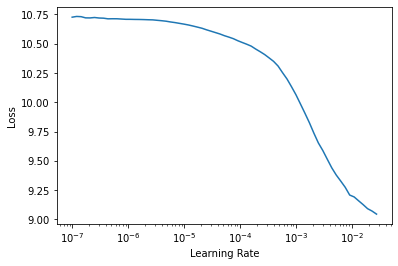

In [10]:
arto_encdec_learn.lr_find()

In [11]:
arto_encdec_learn.fit_one_cycle(3, 1e-4, div=5)  

epoch     train_loss  valid_loss  accuracy  corpus_bleu  time    
0         2.922974    2.830572    0.433868  0.234105     35:13     
1         2.194431    2.091818    0.510804  0.323797     35:25     
2         1.922902    1.921946    0.529961  0.348015     35:20     


In [12]:
arto_encdec_learn.recorder.final_record

(#4) [1.9229015111923218,1.921946406364441,0.529961347579956,0.3480146577647516]

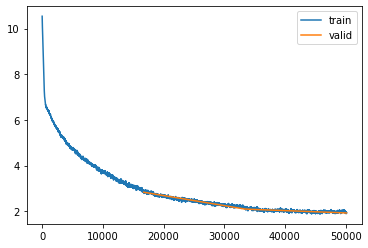

In [13]:
arto_encdec_learn.recorder.plot_loss()

### Standard Attention - w/new attn scaling

Attention scaling chaned from sqrt dim to sqrt k_dim, FF set to 2048, with extra LayerNorms, Xavier init (Enc only), with Bias, with Fixed Pos Enc

In [6]:
import wandb
from fastai.callback.wandb import *

WANDB_NAME = 'std_attn_kdim_scale_INF_ff_2048_extra_LNs_xavier_bias_fixed_pos_enc'
GROUP = 'TEST'     # Group to add a run to, e.g. "LSH" for LSH experiments, "REVERSIBLE" for reversible layers
NOTES = 'Standard attention, scaling Attention with kdim instead of dim, with negative INF masking, FF layer size 2048, with LNs at top of Encoder and Decoder, with Xavier attn init, attn bias and fixed positional encodings'
CONFIG = {}
TAGS =['std_attn','test','enc_dec']

wandb.init(reinit=True, project="reformer-fastai", entity="fastai_community", 
           name=WANDB_NAME, group=GROUP, notes=NOTES,  tags=TAGS) 

wandb: Currently logged in as: morgan (use `wandb login --relogin` to force relogin)


In [7]:
cbs = [CombineInputOutputCallback(), RemoveEOSCallback(dls.o2i[0][EOS]), LossTargetShiftCallback(), WandbCallback(log_model=False, log_preds=False)]

enc_dec_model = TransformerEncDec(en_vocab_sz, ga_vocab_sz, dim=d_model, depth=6, heads=8, 
                 max_seq_len=256, pad_idx=dls.o2i[0][PAD], tie_weights=True, 
                 attn_dropout=0.1, ff_dropout=0.1, emb_dropout=0.1,
                 pos_enc='fixed', d_ff=2048, comb_attn=False)

arto_encdec_learn = Learner(dls, enc_dec_model,
                loss_func=CrossEntropyLossFlat(ignore_index=1), cbs=cbs,
                metrics=[accuracy, CorpusBLEUMetric()]).to_native_fp16()

In [8]:
total_params(arto_encdec_learn.model)[0]

138170872

SuggestedLRs(lr_min=0.003981071710586548, lr_steep=0.033113110810518265)

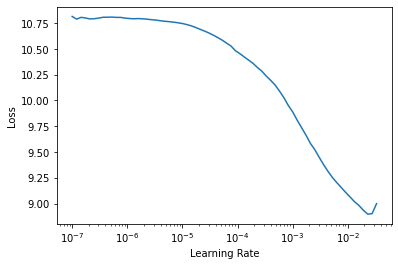

In [9]:
arto_encdec_learn.lr_find()

In [10]:
arto_encdec_learn.fit_one_cycle(3, 1e-4, div=5)  

epoch     train_loss  valid_loss  accuracy  corpus_bleu  time    
0         3.043672    2.952412    0.415738  0.215066     34:08     
1         2.293758    2.220704    0.495684  0.305207     34:36     
2         2.051110    2.054115    0.514906  0.329560     34:44     


In [11]:
arto_encdec_learn.recorder.final_record

(#4) [2.051109790802002,2.0541152954101562,0.5149059295654297,0.3295600801113192]

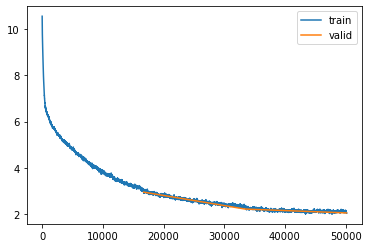

In [12]:
arto_encdec_learn.recorder.plot_loss()

In [6]:
# arto_encdec_learn.encoder??

In [7]:
# arto_encdec_learn.model.encoder??

### Standard Attention - w/new attn scaling + Encoder Causal

Attention scaling chaned from sqrt dim to sqrt k_dim, FF set to 2048, with extra LayerNorms, Xavier init (Enc only), with Bias, with Fixed Pos Enc

In [8]:
import wandb
from fastai.callback.wandb import *

WANDB_NAME = 'std_attn_enc_causal_kdim_scale_INF_ff_2048_extra_LNs_xavier_bias_fixed_pos_enc'
GROUP = 'TEST'     # Group to add a run to, e.g. "LSH" for LSH experiments, "REVERSIBLE" for reversible layers
NOTES = 'Standard attention, with causal encoder masking, scaling Attention with kdim instead of dim, with negative INF masking, FF layer size 2048, with LNs at top of Encoder and Decoder, with Xavier attn init, attn bias and fixed positional encodings'
CONFIG = {}
TAGS =['std_attn','test','enc_dec']

wandb.init(reinit=True, project="reformer-fastai", entity="fastai_community", 
           name=WANDB_NAME, group=GROUP, notes=NOTES,  tags=TAGS) 

wandb: Currently logged in as: morgan (use `wandb login --relogin` to force relogin)


In [9]:
cbs = [CombineInputOutputCallback(), RemoveEOSCallback(dls.o2i[0][EOS]), LossTargetShiftCallback(), WandbCallback(log_model=False, log_preds=False)]

enc_dec_model = TransformerEncDec(en_vocab_sz, ga_vocab_sz, dim=d_model, depth=6, heads=8, 
                 max_seq_len=256, pad_idx=dls.o2i[0][PAD], tie_weights=True, 
                 attn_dropout=0.1, ff_dropout=0.1, emb_dropout=0.1,
                 pos_enc='fixed', d_ff=2048, comb_attn=False)

arto_encdec_learn = Learner(dls, enc_dec_model,
                loss_func=CrossEntropyLossFlat(ignore_index=1), cbs=cbs,
                metrics=[accuracy, CorpusBLEUMetric()]).to_native_fp16()

In [10]:
total_params(arto_encdec_learn.model)[0]

138170872

SuggestedLRs(lr_min=0.005754399299621582, lr_steep=0.04786301031708717)

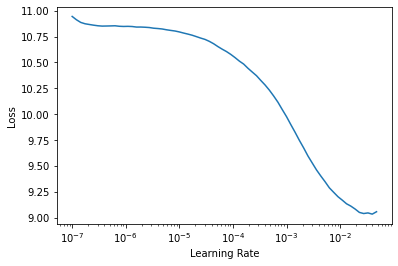

In [11]:
arto_encdec_learn.lr_find()

In [12]:
arto_encdec_learn.fit_one_cycle(3, 1e-4, div=5)  

epoch     train_loss  valid_loss  accuracy  corpus_bleu  time    
0         3.081401    3.028733    0.411547  0.212428     35:11     
1         3.049915    03:02       


KeyboardInterrupt: 

In [ ]:
arto_encdec_learn.recorder.final_record

In [ ]:
arto_encdec_learn.recorder.plot_loss()

# PyTorch 

### PyTorch Transformer Test

In [7]:
import wandb
from fastai.callback.wandb import *

WANDB_NAME = 'pt_encdec'
GROUP = 'TEST'     # Group to add a run to, e.g. "LSH" for LSH experiments, "REVERSIBLE" for reversible layers
NOTES = 'Testing pytorch nn.Transformer performance vs comb_attn EncDec'
CONFIG = {}
TAGS =['pt_encdec','test']

wandb.init(reinit=True, project="reformer-fastai", entity="fastai_community", 
           name=WANDB_NAME, group=GROUP, notes=NOTES,  tags=TAGS) 

wandb: Currently logged in as: morgan (use `wandb login --relogin` to force relogin)


In [6]:
class PositionalEncoding(nn.Module):
    "Encode the position with a sinusoid."
    def __init__(self, d):
        super().__init__()
        self.register_buffer('freq', 1 / (10000 ** (torch.arange(0., d, 2.)/d)))
    
    def forward(self, pos):
        #inp = torch.ger(pos, self.freq)
        inp = torch.ger(pos, self.freq.float())
        enc = torch.cat([inp.sin(), inp.cos()], dim=-1)
        return enc
    
class TransformerEmbedding(nn.Module):
    "Embedding + positional encoding + dropout"
    def __init__(self, vocab_sz, emb_sz, inp_p=0.):
        super().__init__()
        self.emb_sz = emb_sz
        self.embed = Embedding(vocab_sz, emb_sz)
        self.pos_enc = PositionalEncoding(emb_sz)
        self.drop = nn.Dropout(inp_p)
    
    def forward(self, inp): 
        #pos = torch.arange(0, inp.size(1), device=inp.device).float()     
        pos = torch.arange(0, inp.size(1), device=inp.device).float()     
        return self.drop(self.embed(inp) * math.sqrt(self.emb_sz) + self.pos_enc(pos))

    
def to_half(b):
    "Recursively map lists of tensors in `b ` to FP16."
    return apply(lambda x: x.half() if torch.is_floating_point(x) else x, b)

In [7]:
class pt_Transformer(Module):
    def __init__(self, src_vcbsz, trg_vcbsz, n_enc_layers=6, n_dec_layers=6, n_heads=8, d_model=256, # d_head=32, 
                 d_inner=1024, p=0.1, bias=True, scale=True, double_drop=True, pad_idx=1, fp16=True, activation='gelu'):
        self.pad_idx = pad_idx
        self.enc_tfmr_emb = TransformerEmbedding(src_vcbsz, d_model, p)
        self.dec_tfmr_emb = TransformerEmbedding(trg_vcbsz, d_model, 0.)        
        self.final = nn.Linear(d_model, trg_vcbsz)
        self.fp16 = fp16

        self.final.weight = self.dec_tfmr_emb.embed.weight    # Tie Weights
        
        self.transformer_model=torch.nn.Transformer(d_model=d_model, nhead=n_heads, num_encoder_layers=n_enc_layers, 
                                   num_decoder_layers=n_dec_layers, dim_feedforward=d_inner, dropout=p, 
                                   activation=activation, custom_encoder=None, custom_decoder=None)
    
    def forward(self, src, trg, src_mask=None, tgt_mask=None, memory_mask=None, 
                        src_key_padding_mask=None, tgt_key_padding_mask=None, memory_key_padding_mask=None):
        
        enc_emb, dec_emb = self.enc_tfmr_emb(src), self.dec_tfmr_emb(trg)
        
        # Test whether fp16 is being used or not
        if not isinstance(self.transformer_model.encoder.layers[0].self_attn.out_proj.weight,
                          torch.cuda.FloatTensor):
            enc_emb=to_half(enc_emb)
            dec_emb=to_half(dec_emb)
        
        src_mask=self.transformer_model.generate_square_subsequent_mask(src.size(1)).cuda()
        trg_mask=self.transformer_model.generate_square_subsequent_mask(trg.size(1)).cuda()
        
        dec_out = self.transformer_model(enc_emb.permute(1,0,2), dec_emb.permute(1,0,2),
                                         src_mask=src_mask, tgt_mask=trg_mask, memory_mask=None, 
                                         src_key_padding_mask=None, tgt_key_padding_mask=None, 
                                         memory_key_padding_mask=None)
        
        out=self.final(dec_out)
        return out.permute(1,0,2)


In [8]:
pad_idx=1
assert dls.vocab[1][pad_idx] == 'xxpad' 

# en_vocab_sz = len(dls.vocab[0])
# ga_vocab_sz = len(dls.vocab[1])
# d_model = 768
n_heads=8 
d_inner=2048  

In [11]:
cbs = [CombineInputOutputCallback(), RemoveEOSCallback(dls.o2i[0][EOS]), LossTargetShiftCallback(), WandbCallback(log_model=False, log_preds=False)]

pt_model = pt_Transformer(src_vcbsz=en_vocab_sz, trg_vcbsz=ga_vocab_sz, d_model=d_model, d_inner=d_inner)

pt_learn = Learner(dls, pt_model,
                loss_func=CrossEntropyLossFlat(ignore_index=1), cbs=cbs,
                metrics=[accuracy, CorpusBLEUMetric()]).to_native_fp16()

In [12]:
total_params(pt_learn.model)[0]

138170872

SuggestedLRs(lr_min=0.03630780577659607, lr_steep=0.3019951581954956)

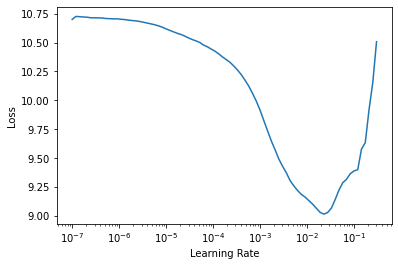

In [13]:
pt_learn.lr_find()

In [14]:
pt_learn.fit_one_cycle(3, 1e-4, div=5)  

epoch     train_loss  valid_loss  accuracy  corpus_bleu  time    
0         2.514077    2.372777    0.479729  0.288535     28:17     
1         1.748080    1.646317    0.558398  0.391034     28:34     
2         1.464647    1.467016    0.579396  0.420738     28:36     


In [15]:
pt_learn.recorder.final_record

(#4) [1.4646466970443726,1.4670156240463257,0.5793959498405457,0.42073837664723107]

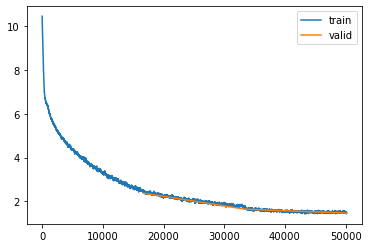

In [16]:
pt_learn.recorder.plot_loss()

### PyTorch Test - Dropout == 0.

In [7]:
import wandb
from fastai.callback.wandb import *

WANDB_NAME = 'pt_zero_dropout_encdec'
GROUP = 'TEST'     # Group to add a run to, e.g. "LSH" for LSH experiments, "REVERSIBLE" for reversible layers
NOTES = 'Testing zero dropout with pytorch nn.Transformer'
CONFIG = {}
TAGS =['enc_dec','test','pt']

wandb.init(reinit=True, project="reformer-fastai", entity="fastai_community", 
           name=WANDB_NAME, group=GROUP, notes=NOTES,  tags=TAGS) 

wandb: Currently logged in as: morgan (use `wandb login --relogin` to force relogin)


In [10]:
pad_idx=1
assert dls.vocab[1][pad_idx] == 'xxpad' 

# en_vocab_sz = len(dls.vocab[0])
# ga_vocab_sz = len(dls.vocab[1])
# d_model = 768
n_heads=8 
d_inner=2048  

In [13]:
cbs = [CombineInputOutputCallback(), RemoveEOSCallback(dls.o2i[0][EOS]), LossTargetShiftCallback(), WandbCallback(log_model=False, log_preds=False)]

pt_model = pt_Transformer(src_vcbsz=en_vocab_sz, trg_vcbsz=ga_vocab_sz, d_model=d_model, d_inner=d_inner,
                         p=0.)

pt_learn = Learner(dls, pt_model,
                loss_func=CrossEntropyLossFlat(ignore_index=1), cbs=cbs,
                metrics=[accuracy, CorpusBLEUMetric()]).to_native_fp16()

In [14]:
total_params(pt_learn.model)[0]

138170872

SuggestedLRs(lr_min=0.03019951581954956, lr_steep=0.25118863582611084)

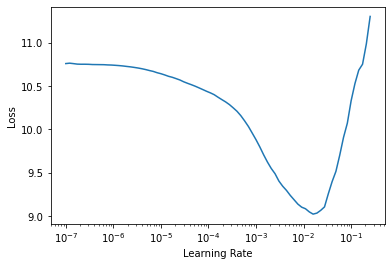

In [15]:
pt_learn.lr_find()

In [16]:
pt_learn.fit_one_cycle(3, 1e-4, div=5)  

epoch     train_loss  valid_loss  accuracy  corpus_bleu  time    
0         2.031505    2.051291    0.513358  0.330985     27:27     
1         1.414669    1.424758    0.580238  0.424066     27:37     
2         1.135697    1.240301    0.602951  0.458558     27:46     


In [17]:
pt_learn.recorder.final_record

(#4) [1.1356974840164185,1.240301251411438,0.6029509902000427,0.45855779408718933]

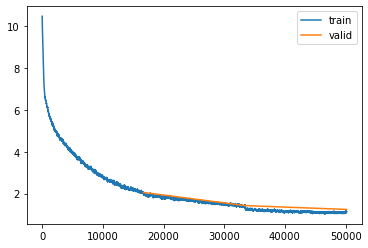

In [18]:
pt_learn.recorder.plot_loss()

### PyTorch - no Enc causal mask, with dropout

In [7]:
import wandb
from fastai.callback.wandb import *

WANDB_NAME = 'pt_no_enc_mask'
GROUP = 'TEST'     # Group to add a run to, e.g. "LSH" for LSH experiments, "REVERSIBLE" for reversible layers
NOTES = 'Testing pytorch nn.Transformer without encoder causal masking'
CONFIG = {}
TAGS =['pt_encdec','test']

wandb.init(reinit=True, project="reformer-fastai", entity="fastai_community", 
           name=WANDB_NAME, group=GROUP, notes=NOTES,  tags=TAGS) 

wandb: Currently logged in as: morgan (use `wandb login --relogin` to force relogin)


In [6]:
class PositionalEncoding(nn.Module):
    "Encode the position with a sinusoid."
    def __init__(self, d):
        super().__init__()
        self.register_buffer('freq', 1 / (10000 ** (torch.arange(0., d, 2.)/d)))
    
    def forward(self, pos):
        #inp = torch.ger(pos, self.freq)
        inp = torch.ger(pos, self.freq.float())
        enc = torch.cat([inp.sin(), inp.cos()], dim=-1)
        return enc
    
class TransformerEmbedding(nn.Module):
    "Embedding + positional encoding + dropout"
    def __init__(self, vocab_sz, emb_sz, inp_p=0.):
        super().__init__()
        self.emb_sz = emb_sz
        self.embed = Embedding(vocab_sz, emb_sz)
        self.pos_enc = PositionalEncoding(emb_sz)
        self.drop = nn.Dropout(inp_p)
    
    def forward(self, inp): 
        #pos = torch.arange(0, inp.size(1), device=inp.device).float()     
        pos = torch.arange(0, inp.size(1), device=inp.device).float()     
        return self.drop(self.embed(inp) * math.sqrt(self.emb_sz) + self.pos_enc(pos))

    
def to_half(b):
    "Recursively map lists of tensors in `b ` to FP16."
    return apply(lambda x: x.half() if torch.is_floating_point(x) else x, b)

In [7]:
class pt_Transformer(Module):
    def __init__(self, src_vcbsz, trg_vcbsz, n_enc_layers=6, n_dec_layers=6, n_heads=8, d_model=256, # d_head=32, 
                 d_inner=1024, p=0.1, bias=True, scale=True, double_drop=True, pad_idx=1, fp16=True, activation='gelu'):
        self.pad_idx = pad_idx
        self.enc_tfmr_emb = TransformerEmbedding(src_vcbsz, d_model, p)
        self.dec_tfmr_emb = TransformerEmbedding(trg_vcbsz, d_model, 0.)        
        self.final = nn.Linear(d_model, trg_vcbsz)
        self.fp16 = fp16

        self.final.weight = self.dec_tfmr_emb.embed.weight    # Tie Weights
        
        self.transformer_model=torch.nn.Transformer(d_model=d_model, nhead=n_heads, num_encoder_layers=n_enc_layers, 
                                   num_decoder_layers=n_dec_layers, dim_feedforward=d_inner, dropout=p, 
                                   activation=activation, custom_encoder=None, custom_decoder=None)
    
    def forward(self, src, trg, src_mask=None, tgt_mask=None, memory_mask=None, 
                        src_key_padding_mask=None, tgt_key_padding_mask=None, memory_key_padding_mask=None):
        
        enc_emb, dec_emb = self.enc_tfmr_emb(src), self.dec_tfmr_emb(trg)
        
        # Test whether fp16 is being used or not
        if not isinstance(self.transformer_model.encoder.layers[0].self_attn.out_proj.weight,
                          torch.cuda.FloatTensor):
            enc_emb=to_half(enc_emb)
            dec_emb=to_half(dec_emb)
        
        #src_mask=self.transformer_model.generate_square_subsequent_mask(src.size(1)).cuda()
        src_mask = None
        trg_mask=self.transformer_model.generate_square_subsequent_mask(trg.size(1)).cuda()
        
        dec_out = self.transformer_model(enc_emb.permute(1,0,2), dec_emb.permute(1,0,2),
                                         src_mask=src_mask, tgt_mask=trg_mask, memory_mask=None, 
                                         src_key_padding_mask=None, tgt_key_padding_mask=None, 
                                         memory_key_padding_mask=None)
        
        out=self.final(dec_out)
        return out.permute(1,0,2)


In [8]:
pad_idx=1
assert dls.vocab[1][pad_idx] == 'xxpad' 

# en_vocab_sz = len(dls.vocab[0])
# ga_vocab_sz = len(dls.vocab[1])
# d_model = 768
n_heads=8 
d_inner=2048  

In [11]:
cbs = [CombineInputOutputCallback(), RemoveEOSCallback(dls.o2i[0][EOS]), LossTargetShiftCallback(), WandbCallback(log_model=False, log_preds=False)]

pt_model = pt_Transformer(src_vcbsz=en_vocab_sz, trg_vcbsz=ga_vocab_sz, d_model=d_model, d_inner=d_inner)

pt_learn = Learner(dls, pt_model,
                loss_func=CrossEntropyLossFlat(ignore_index=1), cbs=cbs,
                metrics=[accuracy, CorpusBLEUMetric()]).to_native_fp16()

In [12]:
total_params(pt_learn.model)[0]

138170872

SuggestedLRs(lr_min=0.03630780577659607, lr_steep=0.3019951581954956)

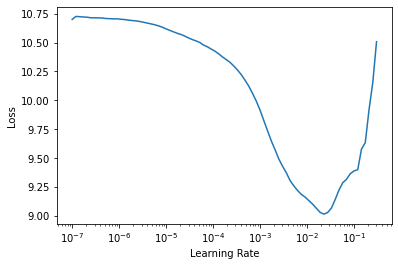

In [13]:
pt_learn.lr_find()

In [14]:
pt_learn.fit_one_cycle(3, 1e-4, div=5)  

epoch     train_loss  valid_loss  accuracy  corpus_bleu  time    
0         2.514077    2.372777    0.479729  0.288535     28:17     
1         1.748080    1.646317    0.558398  0.391034     28:34     
2         1.464647    1.467016    0.579396  0.420738     28:36     


In [15]:
pt_learn.recorder.final_record

(#4) [1.4646466970443726,1.4670156240463257,0.5793959498405457,0.42073837664723107]

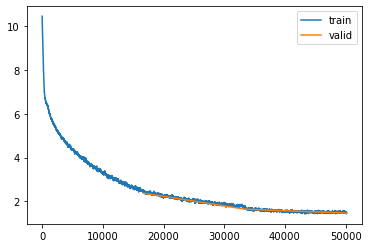

In [16]:
pt_learn.recorder.plot_loss()